# Cascade Classification

One of the key things we can do with vision is object detect.

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their [paper](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf) and improved later by [Rainer Lienhart](http://wiki.opencv.org.cn/images/5/52/MRL-TR-May02-revised-Dec02.pdf).

It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images.

OpenCV provides a training method ( see [Cascade Classifier Training](https://docs.opencv.org/3.4/dc/d88/tutorial_traincascade.html)) or pretrained models, that can be read using the cv2.CascadeClassifierload method. The pre-*trained* models are located in the data folder in the OpenCV installation or can be found [here](https://github.com/opencv/opencv/tree/3.4/data).

In this notebook we will play with some of the provided pre-trained haarcascades models. More on this topic can be found [here](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html).

**HAAR features:**
Each feature is a single value obtained by subtracting sum of pixels under the white rectangle from sum of pixels under the black rectangle.

![](https://drive.google.com/uc?export=view&id=11cnqszDCpUt3fewL3SRBNzM3DF-RNHGw)

For each feature calculation, we need to find the sum of the pixels under white and black rectangles. To solve this, they introduced the integral image. However large your image, it reduces the calculations for a given pixel to an operation involving just four pixels.

**Adaboost:**
Select the best features out of all features. For this, we apply each and every feature on all the training images. For each feature, it finds the best threshold which will classify the faces to positive and negative. Obviously, there will be errors or misclassifications. We select the features with minimum error rate, which means they are the features that most accurately classify the face and non-face images.  (The process is not as simple as this. Each image is given an equal weight in the beginning. After each classification, weights of misclassified images are increased. Then the same process is done. New error rates are calculated. Also new weights. The process is continued until the required accuracy or error rate is achieved or the required number of features are found).

**Cascade of Classifiers:**
Instead of applying all features on a window, the features are grouped into different stages of classifiers and applied one-by-one. (Normally the first few stages will contain very many fewer features). If a window fails the first stage, discard it. We don't consider the remaining features on it. If it passes, apply the second stage of features and continue the process. The window which passes all stages is a face region.

In [34]:
# Download the test image and utils files
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/test.jpg \
    -O test.jpg
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_smile.xml \
    -O haarcascade_smile.xml
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_eye.xml \
    -O haarcascade_eye.xml
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/utils/common.py \
    -O common.py

--2024-04-15 19:42:29--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/test.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240458 (235K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 234.82K   859KB/s    in 0.3s    

2024-04-15 19:42:29 (859 KB/s) - ‘test.jpg’ saved [240458/240458]

--2024-04-15 19:42:29--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, await

In [4]:
# these imports let you use opencv
import cv2 #opencv itself
import common #some useful opencv functions
import numpy as np # matrix manipulations

#the following are to do with this interactive notebook code
%matplotlib inline
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size
pylab.rcParams['figure.figsize'] = (15.0, 12.0) # this controls figure size in the notebook

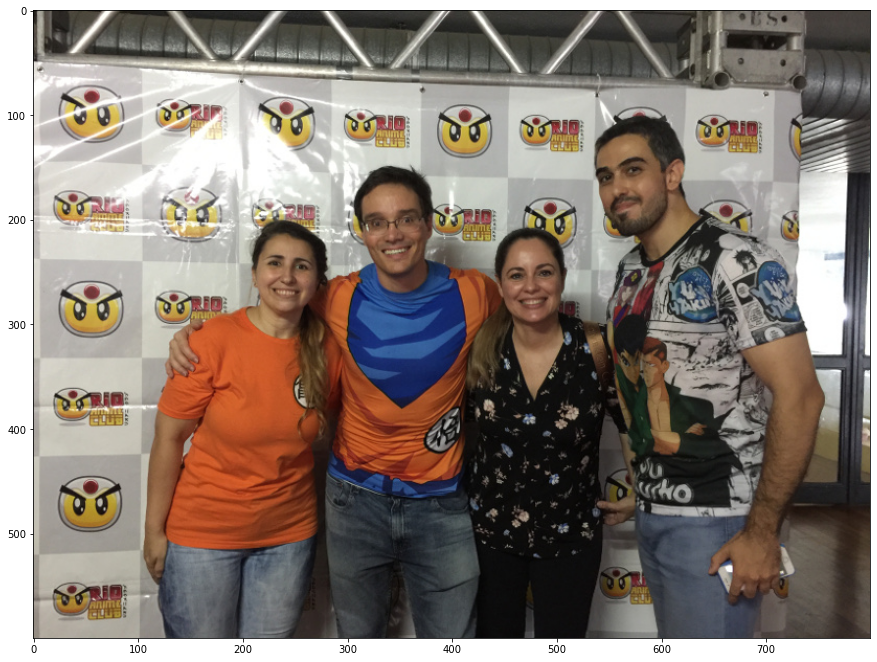

In [2]:
# Load the test image and create a greyscale copy of it to be used in the classifiers

base_image = cv2.imread('test.jpg')
grey = cv2.cvtColor(base_image, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB))

## Face Detection

We will use the pre-trained model haarcascade_frontalface_default.xml to detect faces in the photo. You can find more details about the parameters ofthe detectMultiScale function [here](https://docs.opencv.org/3.4/d1/de5/classcv_1_1CascadeClassifier.html#aaf8181cb63968136476ec4204ffca498).

**Note**: In all examples, I reload the color image again, because the imshow function rewrites the original image with the boxes, but I use the same grayscale image for detection)

Ellipsis

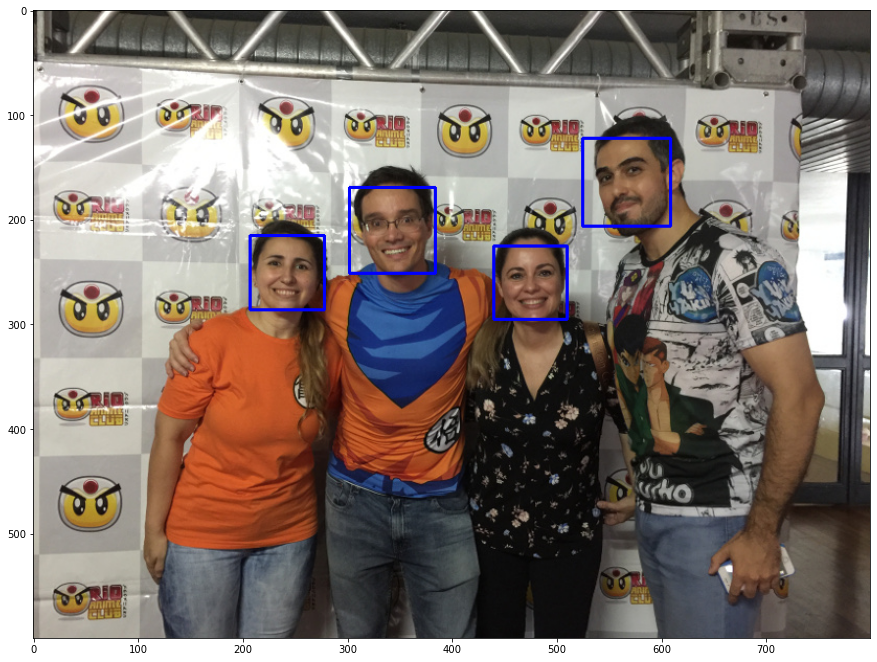

In [5]:
# This is a pre-trained face cascade
test_image = cv2.imread('test.jpg')
facecascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# detectMultiScale(image, scalefactor, minNeighbors)
faces = facecascade.detectMultiScale(grey, 1.3, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(test_image,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

## Smile Detection

We will use the pre-trained model haarcascade_smile.xml to detect smiles on the pictures.

As you can see, it detected the smiles correctly (the right guy, is not giving a full smile) but there are a lot of false positives, as usual in cascade models. Therefore, to improve this, we will only consider detected smiles inside previously detected faces.

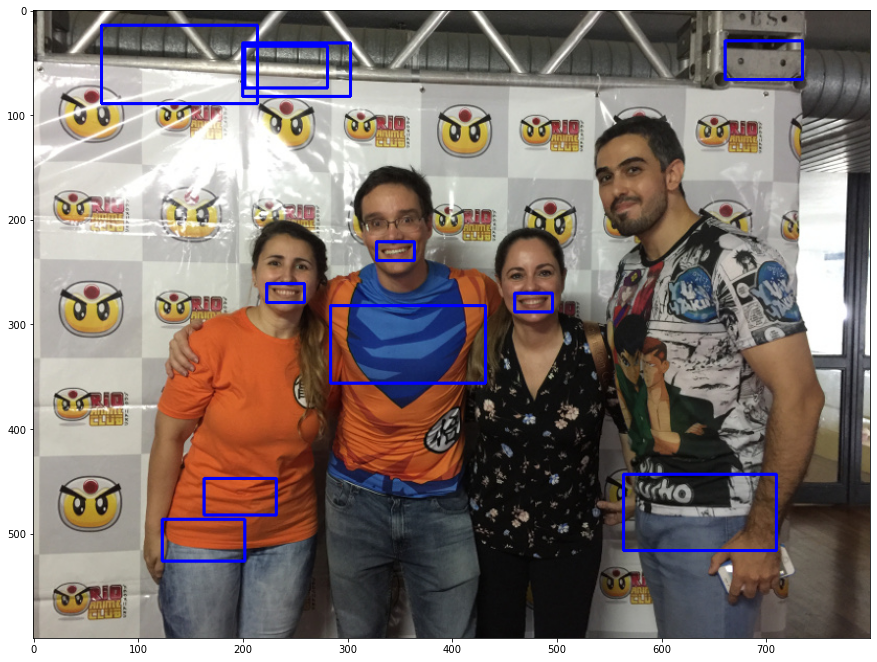

In [6]:
test_image = cv2.imread('test.jpg')
smile_cascade = cv2.CascadeClassifier('haarcascade_smile.xml')
smiles = smile_cascade.detectMultiScale(grey, 1.3, 20)
for (x,y,w,h) in smiles:
    cv2.rectangle(test_image,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

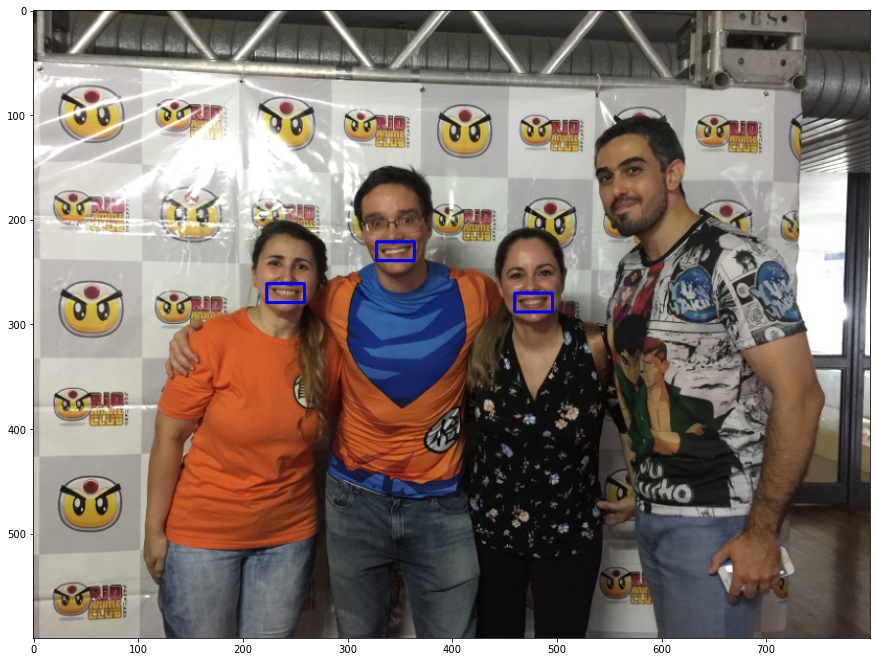

In [8]:
test_image = cv2.imread('test.jpg')
for (x,y,w,h) in faces:
    for(x_s, y_s, w_s, h_s) in smiles:
        if x < x_s < x+w and y < y_s < y+h:
            cv2.rectangle(test_image,(x_s,y_s),(x_s+w_s,y_s+h_s),(255,0,0),2)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

## Eye Detection

Using the pre-trained model haarcascade_frontalface_default.xml to detect faces on the pictures.

Similar to what happened to the smiles, there is a few of false positives, and in this particular case a false negative (probably the glass confused the classifier). So we will use the same approach to filter recognized eyes that are inside faces.

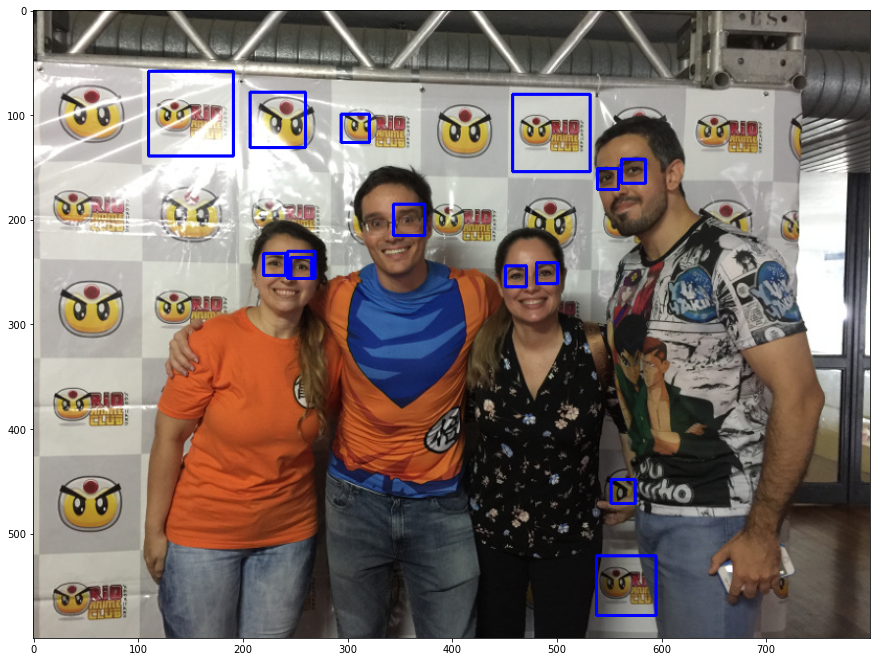

In [9]:
test_image = cv2.imread('test.jpg')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
eyes = eye_cascade.detectMultiScale(grey, 1.3, 1)
for (x,y,w,h) in eyes:
    cv2.rectangle(test_image,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

## Putting all together



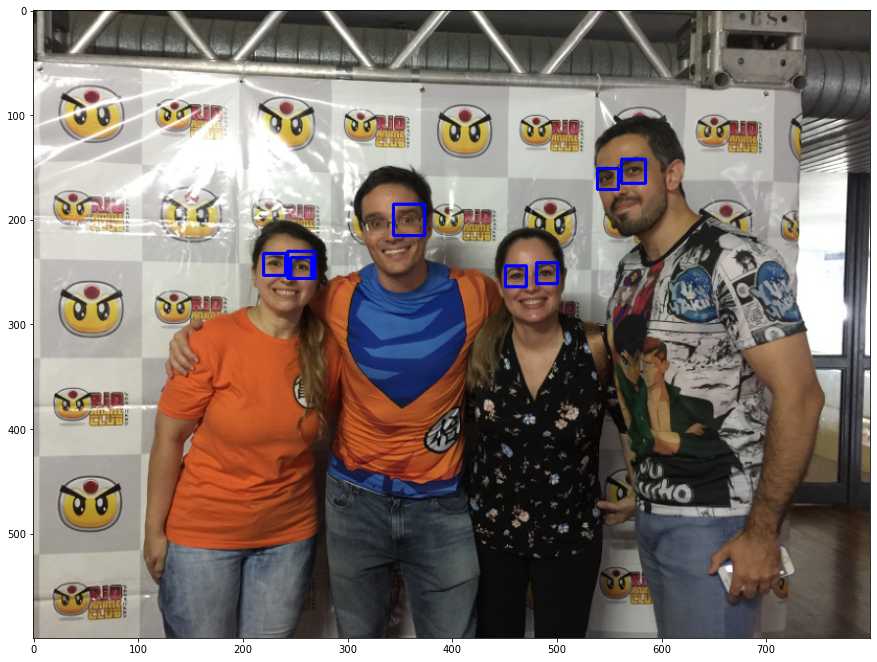

In [11]:
test_image = cv2.imread('test.jpg')
for (x,y,w,h) in faces:
    for(x_e, y_e, w_e, h_e) in eyes:
        if x < x_e < x+w and y < y_e < y+h:
            cv2.rectangle(test_image,(x_e,y_e),(x_e+w_e,y_e+h_e),(255,0,0),2)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

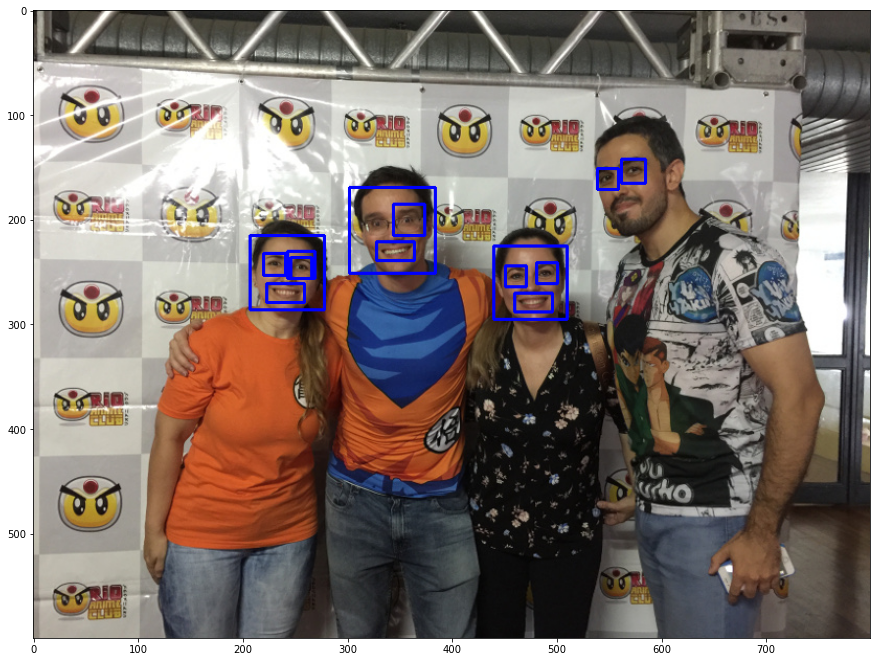

In [13]:
test_image = cv2.imread('test.jpg')
for (x,y,w,h) in faces:
    for(x_s, y_s, w_s, h_s) in smiles:
        if x < x_s < x+w and y < y_s < y+h:
            cv2.rectangle(test_image,(x,y),(x+w,y+h),(255,0,0),2)
            cv2.rectangle(test_image,(x_s,y_s),(x_s+w_s,y_s+h_s),(255,0,0),2)
for (x,y,w,h) in faces:
    for(x_e, y_e, w_e, h_e) in eyes:
        if x < x_e < x+w and y < y_e < y+h:
            cv2.rectangle(test_image,(x_e,y_e),(x_e+w_e,y_e+h_e),(255,0,0),2)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

# Deep Learning-Based Detection

We will load the Faster RCNN Model

In [5]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

model = fasterrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [3]:
weights.meta

{'categories': ['__background__',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'N/A',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'N/A',
  'backpack',
  'umbrella',
  'N/A',
  'N/A',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'N/A',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'N/A',
  'dining table',
  'N/A',
  'N/A',
  'toilet',
  'N/A',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven'

In [6]:
dir(weights)

['__class__',
 '__doc__',
 '__module__',
 'get_state_dict',
 'meta',
 'name',
 'transforms',
 'url',
 'value',
 'verify']

More info at: https://pytorch.org/vision/stable/models.html

As you can see below, simply using image read by OpenCV will not fly. In PyTorch the input has to be a Torch Tensor

In [ ]:
# test_image = cv2.imread('test.jpg')
# output = model(test_image)

Thankfully, PyTorch has IO functionality as well. Note that here we load them differently. The first one will give us a image represented in int8, whereas the second one will give us a image represented in float32.

The reason is, the model only accept float32 input, but later on we will see that most visualization packages need it to be in int

In [22]:
from torchvision.io import read_image

test_image_int = read_image('test.jpg')
test_image_transformed = [transforms(test_image_int)]

output = model(test_image_transformed)

We can see, the output is made of the coordinate of the box, the label of the box, and the confidence that the model has towards the corresponding box. It's important to note that since our model is based on the ResNet, the labels are ResNet labels, which means it cannot detect object that cannot be classified by ResNet

In [23]:
output

[{'boxes': tensor([[269.7858, 153.1293, 447.5948, 594.6334],
          [410.3527, 211.6622, 564.1822, 587.2531],
          [ 99.3222, 196.3414, 288.5386, 596.8712],
          [533.2249, 103.5699, 748.8683, 589.2571],
          [654.3074, 525.7520, 670.5765, 558.8986],
          [551.4921, 285.6917, 683.4067, 597.4536],
          [655.3777, 515.3667, 727.4157, 562.1324],
          [  0.0000,  18.5786, 304.4853, 580.0233],
          [566.2167, 312.0845, 663.3861, 430.3938],
          [540.7143, 529.2354, 573.4772, 564.9435],
          [279.4174, 228.6501, 432.7513, 453.4376],
          [527.1994, 302.5139, 571.9238, 476.0500],
          [118.4157,  85.7174, 151.3887, 113.5657],
          [ 18.7689, 359.8827,  56.9246, 394.2785],
          [656.1981, 525.1210, 700.1172, 565.5314],
          [442.7831, 289.9465, 543.1359, 387.9850],
          [ 17.7232, 546.7473,  54.9885, 579.4543],
          [381.7941, 183.9180, 415.3501, 216.9773],
          [148.7182,  90.0070, 185.1851, 125.8794],
   

In [28]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F

score_threshold = .8
img_with_boxes = [
    draw_bounding_boxes(test_image_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for img, output in zip(test_image_int, output)
]

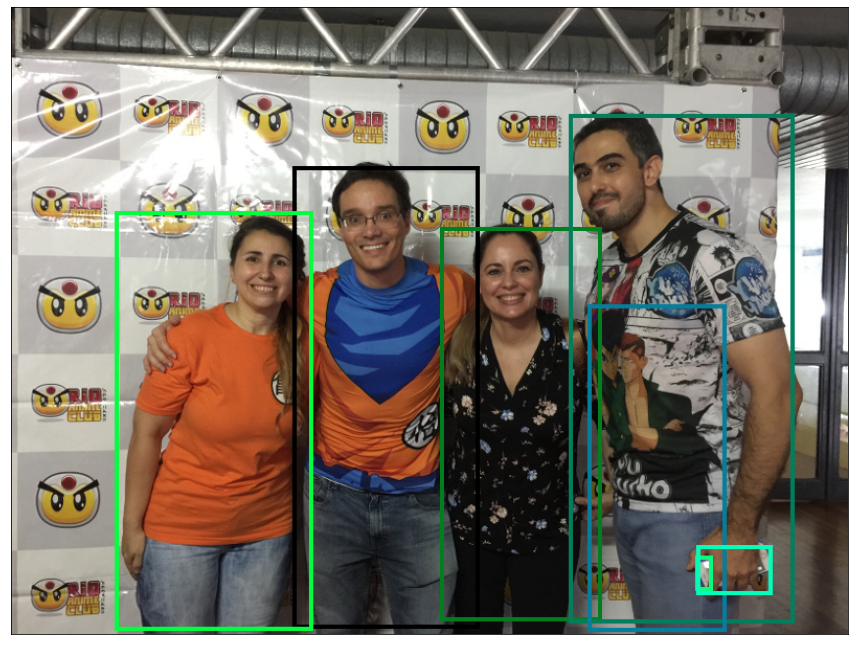

In [29]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(img_with_boxes)
        

In [32]:
mapped_labels = [weights.meta['categories'][i] for i, j in zip(output[0]['labels'], output[0]['scores']) if j > score_threshold]
mapped_labels

['person', 'person', 'person', 'person', 'remote', 'person', 'remote']

--------
# Homework

Given the image below, repeat the exercise we have carried out in the tutorial session by
1. Detecting all the `humans` in the image. 
2. Detecting all the `faces` in the image.
3. Detecting all the `eyes` in the image.

You should show your detection by drawing a bounding box around the detected classes. The input image is shown below and is given in the homework folder `images`.


For your submission, please submit
1. You homework Jupyter Notebook and
2. Upload a copy of the final image with **all** the bounding boxes drawn around the 3 classes of interests.

You can submit your homework here: https://forms.gle/D7vz7YM7xdvUisBM7

![](images/NewYork427.png)